## Model (XGBoost)

We are going to use the XGBoost Model in order to predict whether the customers or not are going to go up to the end of the ideal journey, i.e. our target is going to be order ships.

* Libraries required

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Librarie for Preprocessing (By Us)
from utils import *

# Data Structures
from collections import defaultdict

# Model Libraries
from xgboost import XGBClassifier

# Import torch
import torch
import torch.nn as nn

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Optimización de hiperparámetros
import optuna

from skopt import BayesSearchCV
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

# # Downsample majority class
from sklearn.utils import resample

%matplotlib inline
pd.options.mode.chained_assignment = None

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Retrieval

We retrieve the data from the original source, i.e. the one that is uncleaned and unprocessed. Also we retrive the event definition dataset:

In [2]:
#data = pd.read_csv('../../1. Data/export.csv')
# data = pd.read_csv('../../1. Data/smaller_sample.csv')
# event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

#### Execute only if working with the original dataset

In [3]:
# event_defs.drop(columns=['event_name'], inplace=True)
# event_defs.rename(columns={'event_definition_id':'ed_id'}, inplace=True)

* As the original dataset does not have some already-merged variables then we have to manually do it. This takes approximately 31 secs.

In [4]:
# data = pd.merge(data, event_defs, on='ed_id', how='left')
# event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

#### If working with the sample dataset, execute from here

Then we call the **get_classification_dataset** function with *n_events = $5$* (this parameter could be changed everytime and depends only in the number of sequential events we would like to consider in the last **first_n_events** column). This takes approx **2:07** mins to run (in the small_sample case)

In [5]:
# number_events_fixed = 20
# col_name = 'first_' + str(number_events_fixed) +'_events'

# df = get_classification_dataset(data, event_defs, n_events=number_events_fixed)
# df.reindex(sorted(df.columns), axis=1)

In [6]:
df = pd.read_csv('../../1. Data/export_n_20.csv').drop(columns=['Unnamed: 1'])
df.reindex(sorted(df.columns), axis=1)
df.head()

,customer_id,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,first_purchase,...,downpayment_cleared,order_ships,max_milestone,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,708,2,91,False,2,True,4,60.5,True,True,...,True,True,6.0,True,False,2.0,0.0,2045.0,[12 4 4 4 4 24 29 4 4 4 4 4 4 4 4 ...,[0.000000e+00 1.100000e+03 2.851830e+05 4.5900...
1,3591,1,63,False,1,False,4,58.0,True,False,...,False,False,1.0,True,False,2.0,0.0,218.0,[12 4 11 5 5 4 4 4 4 4 4 4 11 4 4 ...,[ 0. 218. 89. 20. 28. 24. 95. 75. 87. ...
2,5414,1,27,True,1,False,4,24.0,True,False,...,False,False,1.0,True,False,2.0,4544216.0,549.0,[21 12 4 2 4 11 4 11 5 4 11 4 11 5 4 ...,[0.000000e+00 1.783191e+06 5.490000e+02 2.1051...
3,6072,1,8,True,1,False,4,6.0,True,False,...,False,False,1.0,True,False,2.0,1089605.0,260.0,[12 4 2 4 24 21 0 0 0 0 0 0 0 0 0 ...,[0.000000e+00 2.600000e+02 6.630000e+03 1.0896...
4,8039,1,11,True,1,False,19,11.0,True,False,...,False,False,1.0,False,False,2.0,30400833.0,21684.0,[19 19 19 19 19 3 19 19 12 2 4 0 0 0 0 ...,[0.0000000e+00 5.8000000e+01 2.0000000e+00 3.0...


In [7]:
#cust_ids = df.index
#cust_ids = [x[0] for x in cust_ids]
#df.reset_index(drop=True, inplace=True)
#df['customer_id'] = cust_ids
#df.head()

The models:
* XGBoost
* LGBM
* LR
* GB
* ADABoost
* Neural Network
* Random Forest

* Clustering for improving the accuracy of the models by looking at the errors
* Boosting algotithms are performing better
* Causationg learning
* Discover variable
* Analytics
* Markov Chain

In [8]:
df

,customer_id,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,first_purchase,...,downpayment_cleared,order_ships,max_milestone,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,708,2,91,False,2,True,4,60.5,True,True,...,True,True,6.0,True,False,2.0,0.0,2045.0,[12 4 4 4 4 24 29 4 4 4 4 4 4 4 4 ...,[0.000000e+00 1.100000e+03 2.851830e+05 4.5900...
1,3591,1,63,False,1,False,4,58.0,True,False,...,False,False,1.0,True,False,2.0,0.0,218.0,[12 4 11 5 5 4 4 4 4 4 4 4 11 4 4 ...,[ 0. 218. 89. 20. 28. 24. 95. 75. 87. ...
2,5414,1,27,True,1,False,4,24.0,True,False,...,False,False,1.0,True,False,2.0,4544216.0,549.0,[21 12 4 2 4 11 4 11 5 4 11 4 11 5 4 ...,[0.000000e+00 1.783191e+06 5.490000e+02 2.1051...
3,6072,1,8,True,1,False,4,6.0,True,False,...,False,False,1.0,True,False,2.0,1089605.0,260.0,[12 4 2 4 24 21 0 0 0 0 0 0 0 0 0 ...,[0.000000e+00 2.600000e+02 6.630000e+03 1.0896...
4,8039,1,11,True,1,False,19,11.0,True,False,...,False,False,1.0,False,False,2.0,30400833.0,21684.0,[19 19 19 19 19 3 19 19 12 2 4 0 0 0 0 ...,[0.0000000e+00 5.8000000e+01 2.0000000e+00 3.0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1665369,2147480920,1,110,True,1,False,4,101.0,True,False,...,False,False,1.0,True,False,2.0,63031.0,1892475.0,[ 2 19 19 19 19 19 19 19 3 19 12 4 4 4 11 ...,[0.00000e+00 6.30310e+04 1.00000e+00 6.00000e+...
1665370,2147481037,1,7,True,1,False,2,6.0,True,False,...,False,False,1.0,False,False,2.0,12654.0,21600.0,[12 2 5 11 4 6 0 0 0 0 0 0 0 0 0 ...,[ 0. 21600. 12654. 0. 0. 0. ...
1665371,2147482120,1,3,True,1,False,2,3.0,True,False,...,False,False,1.0,False,False,2.0,0.0,21600.0,[12 19 2 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0. 17755. 3845. 0. 0. 0. ...
1665372,2147483471,1,9,False,1,False,4,6.0,True,False,...,False,False,1.0,True,False,2.0,0.0,288.0,[12 4 4 4 21 21 0 0 0 0 0 0 0 0 0 ...,[0.000000e+00 2.880000e+02 1.600000e+02 1.3939...


In [9]:
result = []

number_events_fixed = 20
col_name = 'first_' + str(number_events_fixed) +'_events'

for item in list(df[col_name]):
    # Extract numbers from the string and convert them to integers
    numbers = [int(num) for num in item.replace('[', '').replace(']', '').split()]
    
    # Ensure the list has a length of 5, filling with zeros if necessary
    numbers += [0] * (number_events_fixed - len(numbers))
    
    # Append the result to the final list
    result.append(numbers)
    
df[col_name] = result

In [10]:
result2 = []

for item in list(df['time_since_last_event']):
    # Extract numbers from the string and convert them to integers
    numbers = [float(num) for num in item.replace('[', '').replace(']', '').split()]
    
    # Ensure the list has a length of 5, filling with zeros if necessary
    #numbers += [0] * (number_events_fixed - len(numbers))
    
    # Append the result to the final list
    result2.append(numbers)
    
df['time_since_last_event'] = result2

### Selecting the customers with a certain amount of events -- NO LONGER NEEDED AS ALL HAVE EXACTLY THE SAME AMOUNT OF EVENTS

We select the customers with certain fixed amount of events 

In [11]:
# number_events_fixed = 20

# col_name = 'first_' + str(number_events_fixed) +'_events'

# lengths = df[col_name].apply(lambda x: len(x))
# print(lengths.value_counts())

In [12]:
# idxs = lengths[lengths == number_events_fixed].index
# df_selected = df.loc[idxs]

### New dataset without the following columns:

* First 5 events
* max_milestone
* downpayment_cleared
* first_purchase
* downpayment_received
* account_activitation

We are going to drop the next columns because they give information for the outcome of the target variable and therefore they are not going to be used in the model because we want to predict in an early stage of the journey if the customer is going to go up to the end of the journey.

In [13]:
cust_ids_saved = df['customer_id']

In [14]:
df.drop(columns=['max_milestone', 'downpayment_cleared', 'first_purchase', 'downpayment_received', 'account_activitation', 'customer_id'], inplace=True)
df.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,2,91,False,2,True,4,60.5,True,True,True,False,2.0,0.0,2045.0,"[12, 4, 4, 4, 4, 24, 29, 4, 4, 4, 4, 4, 4, 4, ...","[0.0, 1100.0, 285183.0, 459.0, 127.0, 0.0, 158..."
1,1,63,False,1,False,4,58.0,True,False,True,False,2.0,0.0,218.0,"[12, 4, 11, 5, 5, 4, 4, 4, 4, 4, 4, 4, 11, 4, ...","[0.0, 218.0, 89.0, 20.0, 28.0, 24.0, 95.0, 75...."
2,1,27,True,1,False,4,24.0,True,False,True,False,2.0,4544216.0,549.0,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...","[0.0, 1783191.0, 549.0, 21051.0, 4544216.0, 2...."
3,1,8,True,1,False,4,6.0,True,False,True,False,2.0,1089605.0,260.0,"[12, 4, 2, 4, 24, 21, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 260.0, 6630.0, 1089605.0, 0.0, 6059995.0..."
4,1,11,True,1,False,19,11.0,True,False,False,False,2.0,30400833.0,21684.0,"[19, 19, 19, 19, 19, 3, 19, 19, 12, 2, 4, 0, 0...","[0.0, 58.0, 2.0, 3.0, 7.0, 1.0, 0.0, 1.0, 12.0..."


### Changing the boolean columns to 0 and 1

In [15]:
# Setting float values for all the columns except the last 2
df = df.astype({col: 'float' for col in df.columns[:-2]})
df.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,has_pre_application,initial_device,time_in_discover,time_in_apply,first_20_events,time_since_last_event
0,2.0,91.0,0.0,2.0,1.0,4.0,60.5,1.0,1.0,1.0,0.0,2.0,0.0,2045.0,"[12, 4, 4, 4, 4, 24, 29, 4, 4, 4, 4, 4, 4, 4, ...","[0.0, 1100.0, 285183.0, 459.0, 127.0, 0.0, 158..."
1,1.0,63.0,0.0,1.0,0.0,4.0,58.0,1.0,0.0,1.0,0.0,2.0,0.0,218.0,"[12, 4, 11, 5, 5, 4, 4, 4, 4, 4, 4, 4, 11, 4, ...","[0.0, 218.0, 89.0, 20.0, 28.0, 24.0, 95.0, 75...."
2,1.0,27.0,1.0,1.0,0.0,4.0,24.0,1.0,0.0,1.0,0.0,2.0,4544216.0,549.0,"[21, 12, 4, 2, 4, 11, 4, 11, 5, 4, 11, 4, 11, ...","[0.0, 1783191.0, 549.0, 21051.0, 4544216.0, 2...."
3,1.0,8.0,1.0,1.0,0.0,4.0,6.0,1.0,0.0,1.0,0.0,2.0,1089605.0,260.0,"[12, 4, 2, 4, 24, 21, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 260.0, 6630.0, 1089605.0, 0.0, 6059995.0..."
4,1.0,11.0,1.0,1.0,0.0,19.0,11.0,1.0,0.0,0.0,0.0,2.0,30400833.0,21684.0,"[19, 19, 19, 19, 19, 3, 19, 19, 12, 2, 4, 0, 0...","[0.0, 58.0, 2.0, 3.0, 7.0, 1.0, 0.0, 1.0, 12.0..."


### Embedding for the sequential events and for the times

We are going to capture the information of the sequential events in the first 5 events by transforming this sequence into a vector. As this column contains arrays of the fixed specified length, we cannot parse it directly to our model.

#### Function

In [16]:
class Embedding(nn.Module):
    def __init__(self, embedding_dim, n_events=5):
        super().__init__()
        self.fc1 = nn.Linear(n_events, embedding_dim, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#### Embedding the events

In [17]:
# Embed event id sequence into smaller dimension
event_id = df[col_name]
event_id = torch.tensor(event_id.to_list()).float()
emb = Embedding(5, number_events_fixed)
event_id = emb(event_id)

#### Embedding the times

In [18]:
# Embed event id sequence into smaller dimension
times = df['time_since_last_event']
times = torch.tensor(times.to_list()).float()
emb_t = Embedding(5, number_events_fixed)
times = emb(times)

In [19]:
event_id_df = pd.DataFrame(event_id.detach().numpy(), columns=[f'event_id_{i}' for i in range(5)])
times_df = pd.DataFrame(times.detach().numpy(), columns=[f'time_{i}' for i in range(5)])

df.drop(columns=[col_name, 'time_since_last_event'], inplace=True)
df.reset_index(drop=True, inplace=True)

new_dfx = pd.concat([df, event_id_df, times_df], axis=1)
new_dfx.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,order_ships,has_prospecting,...,event_id_0,event_id_1,event_id_2,event_id_3,event_id_4,time_0,time_1,time_2,time_3,time_4
0,2.0,91.0,0.0,2.0,1.0,4.0,60.5,1.0,1.0,1.0,...,-0.219874,1.592075,-3.181866,-3.498702,0.123576,-34628.226562,6.087513e+04,-1.308325e+05,-1.353892e+05,-2.675368e+04
1,1.0,63.0,0.0,1.0,0.0,4.0,58.0,1.0,0.0,1.0,...,0.080791,0.889588,-1.704063,-1.875047,0.443409,0.487424,1.724741e+00,-3.137260e+00,-2.306667e+00,3.778995e+00
2,1.0,27.0,1.0,1.0,0.0,4.0,24.0,1.0,0.0,1.0,...,0.248657,0.797350,-1.463176,-1.603863,0.736123,-28176.343750,4.953296e+04,-1.064560e+05,-1.101637e+05,-2.176897e+04
3,1.0,8.0,1.0,1.0,0.0,4.0,6.0,1.0,0.0,1.0,...,0.806168,0.869753,0.242574,-1.886398,-0.116361,638219.875000,2.942787e+05,-8.821640e+04,-8.822402e+05,4.743933e+05
4,1.0,11.0,1.0,1.0,0.0,19.0,11.0,1.0,0.0,0.0,...,-0.779458,1.370257,-2.944950,-3.047518,-0.602207,-68330.171875,1.762798e+06,-3.438258e+06,-3.257468e+06,1.514602e+06


In [44]:
new_dfx.columns

Index(['num_journeys', 'max_journey', 'discover', 'number_accounts',
       'one_more_journey', 'most_repeated_event', 'average_length_seq',
       'approved_credit', 'order_ships', 'has_prospecting',
       'has_pre_application', 'initial_device', 'time_in_discover',
       'time_in_apply', 'event_id_0', 'event_id_1', 'event_id_2', 'event_id_3',
       'event_id_4', 'time_0', 'time_1', 'time_2', 'time_3', 'time_4'],
      dtype='object')

In [53]:
numerical = new_dfx.loc[:,['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 'time_in_discover', 'time_in_apply', 'event_id_0', 'event_id_1', 'event_id_2', 'event_id_3',
       'event_id_4', 'time_0', 'time_1', 'time_2', 'time_3', 'time_4']]

y = new_dfx['order_ships']

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Variance of each component: [0.67519559 0.27904737 0.03540222]

 Total Variance Explained: 98.96


<Figure size 640x480 with 0 Axes>

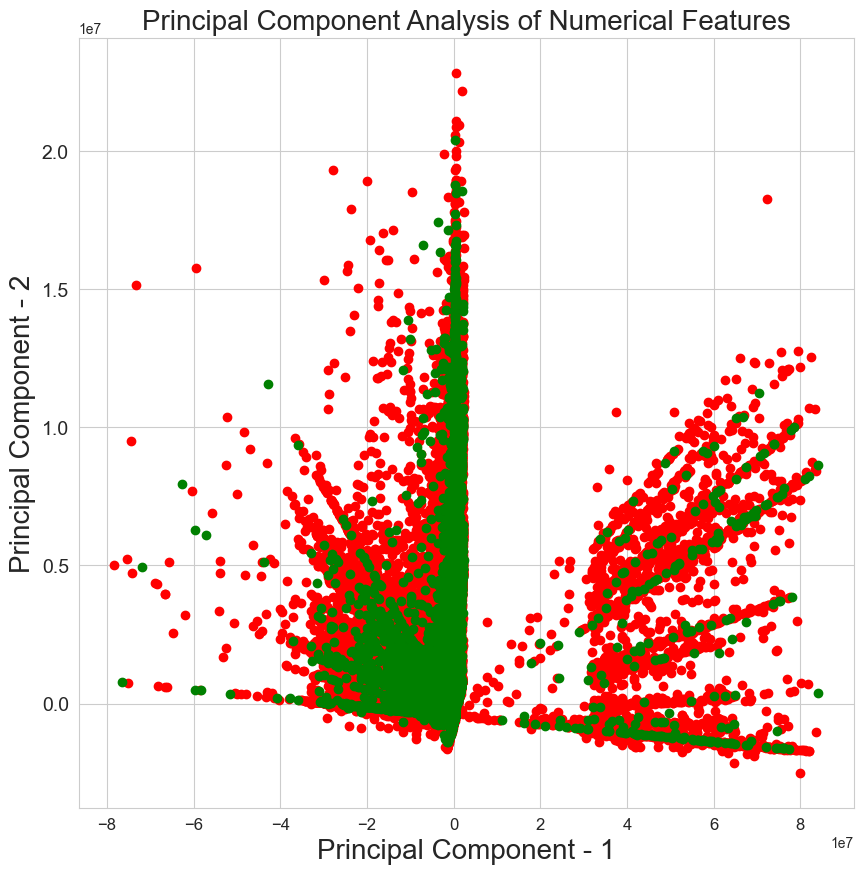

In [57]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(numerical)

# Variance explained
print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

# Plot the graph
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)

# Color mapping for classes
colors = ['r', 'g']
for i, color in zip(range(2), colors):
    plt.scatter(principalComponents[y == i, 1], principalComponents[y == i, 2], color=color, label=f'Class {i}')

plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Numerical Features",fontsize=20)
plt.show()

In [59]:
import umap

# Perform UMAP
umap_emb = umap.UMAP(n_components=2)
X_umap = umap_emb.fit_transform(numerical)

# Plot UMAP
plt.figure(figsize=(8, 6))
for i, color in zip(range(3), colors):
    plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=color, label=f'Class {i}')

plt.title('UMAP with Class Separation')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)
plt.show()

ModuleNotFoundError: No module named 'umap'

In [20]:
# df.to_csv('data_no_embeddings.csv', index=False)
# new_dfx.to_csv('data_with_embeddings.csv', index=False)

In [21]:
new_dfx['order_ships'].value_counts()

order_ships
0.0    1344699
1.0     320675
Name: count, dtype: int64

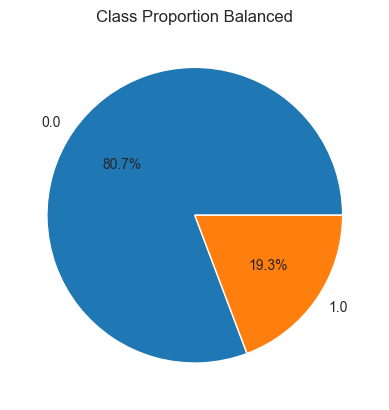

In [22]:
# Separate input features (X) and target variable (y)
y = new_dfx['order_ships'].to_numpy()
X = new_dfx.drop(columns=['order_ships']).to_numpy()

# Plotting the class proportion
plt.pie(new_dfx['order_ships'].value_counts(), labels=new_dfx['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion Balanced')
plt.show()

### Balancing the data

In [23]:
# Separate majority and minority classes according to our target variable
df_majority = new_dfx[new_dfx['order_ships'] == 0]
df_minority = new_dfx[new_dfx['order_ships'] == 1]

print('Shape of majority class:', df_majority.shape)
print('Shape of minority class:', df_minority.shape)

Shape of majority class: (1344699, 24)
Shape of minority class: (320675, 24)


#### Upsampling the data

If we want to approach the problem of the unbalanced data we can upsample the minority class in order to have a balanced dataset. But in order to do this we have to split the data into train and test and then upsample the train data.

In [24]:
# # Separating the training and testing data
# X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'),
#                                                     new_dfx['order_ships'],
#                                                     test_size=0.2,
#                                                     random_state=2024)

# # Upsample minority class from the training data using X_train and y_train
# df_majority = X_train[y_train == 0]
# df_minority = X_train[y_train == 1]

# # Upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=53731,    # to match majority class
#                                  random_state=2024)

# # Combine majority class with upsampled minority class
# X_train = pd.concat([df_majority, df_minority_upsampled])
# y_train = [0]*53731 + [1]*53731

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

#### Downsampling the data

* Random choice method

In [25]:
# # Downsample majority class
# df_downsampled = df_majority.sample(n=df_minority.shape[0], replace=False, random_state=2024)

# # Concatenate the minority class with the downsampled majority class
# df_sampled = pd.concat([df_downsampled, df_minority])

# #Dropping the indexes from the original dataset
# df_majoritie_excluded = df_majority.drop(index=df_downsampled.index)

* Function method

In [26]:
# Downsample majority class
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,    # sample without replacement
#                                  n_samples=df_minority.shape[0],     # to match minority class
#                                  random_state=2024) # reproducible results

# # Combine minority class with downsampled majority class
# df_sampled = pd.concat([df_majority_downsampled, df_minority])

# # Display new class counts
# df_sampled['order_ships'].value_counts()

### Separating the data and the target

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [27]:
# Setting the dataset we are using to train-test the model
df_final = new_dfx
df_final['order_ships'].value_counts()

order_ships
0.0    1344699
1.0     320675
Name: count, dtype: int64

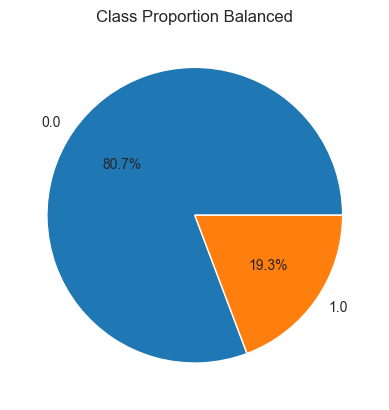

In [28]:
# Separate input features (X) and target variable (y)
y = df_final['order_ships'].to_numpy()
X = df_final.drop(columns=['order_ships']).to_numpy()

# Plotting the class proportion
plt.pie(df_final['order_ships'].value_counts(), labels=df_final['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion Balanced')
plt.show()

## XGBoost Model

We can see that the class proportion is not balanced, but we are going to use the **scale_pos_weight** parameter in the XGBoost model in order to balance the classes. One quick rule of thumb to consider is that the scale_pos_weight should be equal to the ratio of the number of negative class to the positive class.

$$scale\_pos\_weight = \frac{negatives}{positives}$$

and therefore:

$$scale\_pos\_weight = \frac{negatives}{positives} = \frac{1344699}{320675} = 4.1933390504$$

### Hyperparameter Fine-Tuning Function For XGBoost

The next function is going to be used in order to fine-tune the hyperparameters of the XGBoost model by employing a strategy called Tree-structured Parzen Estimator (TPE). The TPE algorithm is a Bayesian optimization algorithm that explores the hyperparameter space efficiently.

In [29]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = f1_score(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

### Simple Train-Test Split

In [30]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Hyperparameter space
options = {'max_depth': hp.quniform('max_depth', 1, 30, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 15),
           'reg_lambda': hp.uniform('reg_lambda', 1, 15),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
           'random_state': 2024,
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   early_stopping_rounds=30),
            space=options,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,#)
            timeout=60*15) # 5 minutos de tiempo de ejecución

best

  0%|          | 0/50 [02:06<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [31]:
best = {'colsample_bytree': 0.8402686732798905,
 'gamma': 0.33500938939497493,
 'learning_rate': 0.11639038601702939,
 'max_depth': 29.0,
 'min_child_weight': 0.007112406074059109,
 'reg_alpha': 12.120675104275712,
 'reg_lambda': 10.436126134904793,
 'scale_pos_weight': 7.120154797113259,
 'subsample': 0.9389849014442088}

UP (second method):
{'colsample_bytree': 0.5365132685746051,
 'gamma': 0.003240176407095462,
 'learning_rate': 0.05613530875599775,
 'max_depth': 29.0,
 'min_child_weight': 0.007123490594595419,
 'reg_alpha': 0.09922000266206621,
 'reg_lambda': 3.3125933526084195,
 'scale_pos_weight': 1.324702804961199,
 'subsample': 0.798677212830813}

 UP (first method):
 

In [32]:
# best = {'colsample_bytree': 0.5365132685746051,
#  'gamma': 0.003240176407095462,
#  'learning_rate': 0.05613530875599775,
#  'max_depth': 29.0,
#  'min_child_weight': 0.007123490594595419,
#  'reg_alpha': 0.09922000266206621,
#  'reg_lambda': 3.3125933526084195,
#  'scale_pos_weight': 4.1933390504,
#  'subsample': 0.798677212830813}

Metrics : 
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89    268699
         1.0       0.55      0.90      0.68     64376

    accuracy                           0.84    333075
   macro avg       0.76      0.86      0.79    333075
weighted avg       0.89      0.84      0.85    333075



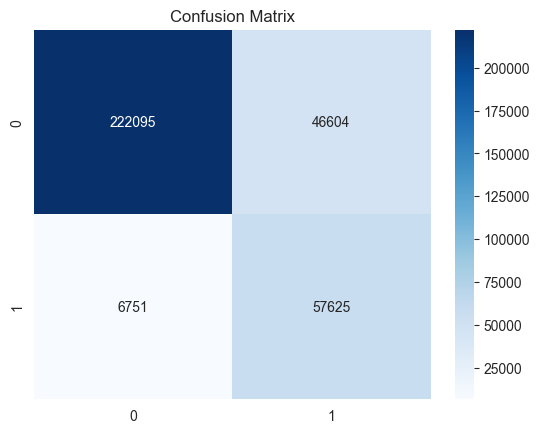

In [33]:
# Set the max_depth as an integer
best['max_depth'] = int(best['max_depth'])

# Train the model
xgb = XGBClassifier(**best,
                    n_estimators=100,
                    random_state = 2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# y_test_2 = df_majoritie_excluded['order_ships'].to_numpy()
# X_test_2 = df_majoritie_excluded.drop(columns=['order_ships']).to_numpy()

# y_pred2 = xgb.predict(X_test_2)
# print(classification_report(y_test_2, y_pred2))
# sns.heatmap(confusion_matrix(y_test_2, y_pred2), annot=True, fmt='d', cmap='Blues')

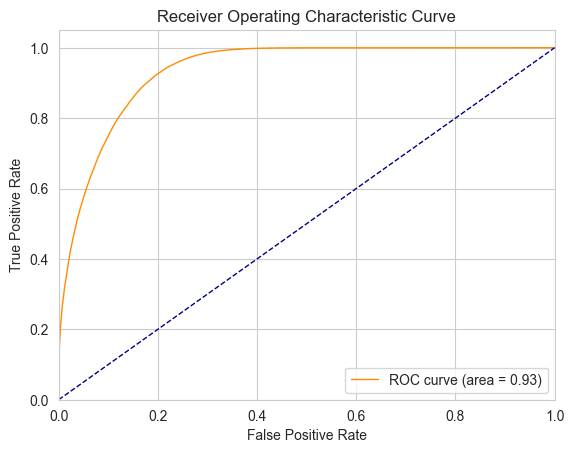

In [35]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

### Most Important Features

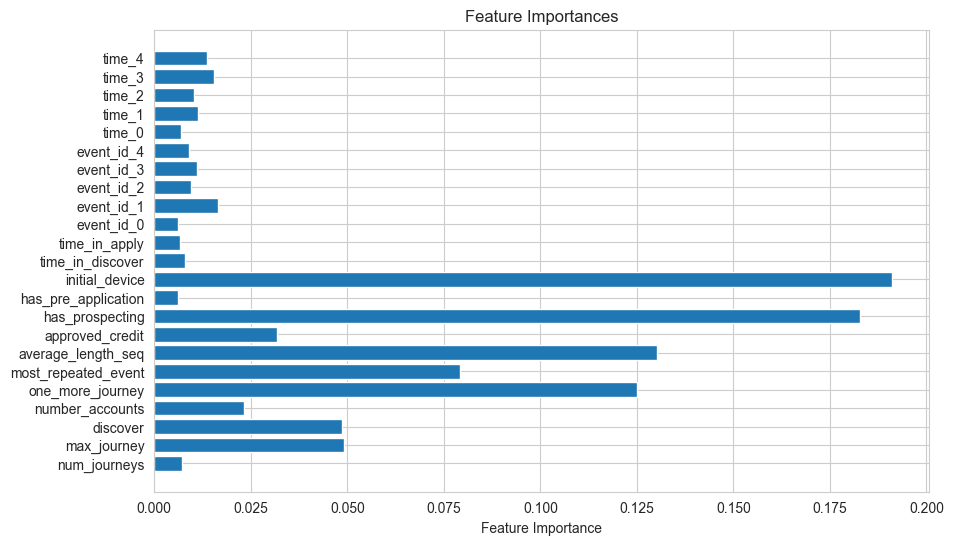

In [36]:
# # Train the model
# xgb = XGBClassifier(**best,
#                     random_state=2024)
# xgb.fit(X_train,y_train)

# Columns
x = list(df_final.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Cross Validation

For the original data set with the customers it takes approximately 12m 58s to run in my local machine.

In [37]:
# Model
xgb = XGBClassifier(**best, n_estimators=100)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
scores = cross_val_score(xgb, X, y, cv=cv, scoring='f1')

print('Mean F1 score : ', scores.mean())
print('Std F1 : ', scores.std())

KeyboardInterrupt: 

In [ ]:
print('Mean Accuracy score : ', scores.mean())
print('Std Accuracy : ', scores.std())

## Ensemble Model

In [38]:
new_dfx = new_dfx.dropna()

In [39]:
X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns=['order_ships']), new_dfx['order_ships'], test_size=0.2, random_state=2024)

In [42]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# create the individual models
clf1 = LogisticRegression(random_state=2024)
clf2 = RandomForestClassifier(random_state=2024)
clf3 = GaussianNB()
clf4 = XGBClassifier(**best, 
                     n_estimators=100,
                     random_state=2024)
clf5 = LGBMClassifier(random_state=2024)
#clf6 = GradientBoostingClassifier(random_state=2024)
#clf7 = AdaBoostClassifier(random_state=2024)
#clf8 = SVC(random_state=2024)
#clf9 = DecisionTreeClassifier(random_state=2024)

# create the ensemble model
eclf = VotingClassifier(
    estimators=[('lr', clf1),
                ('rf', clf2),
                ('gnb', clf3),
                ('xgb', clf4),
                #('svc', clf8),
                ('lgbm', clf5),],
                #('gbc', clf6),
                #('abc', clf7),
                #('dtc', clf9)],
    voting='hard')

# fit the ensemble model
eclf = eclf.fit(X_train, y_train)

# make predictions
y_pred = eclf.predict(X_test)

# evaluate the ensemble model
print('Metrics : ')
print(classification_report(y_test, y_pred))

/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

[LightGBM] [Info] Number of positive: 256125, number of negative: 1075860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3611
[LightGBM] [Info] Number of data points in the train set: 1331985, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192288 -> initscore=-1.435210
[LightGBM] [Info] Start training from score -1.435210


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:767

Metrics : 


/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/danielmalvaez/miniconda3/envs/Kernelsote/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will

              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92    268496
         1.0       0.70      0.56      0.62     64501

    accuracy                           0.87    332997
   macro avg       0.80      0.75      0.77    332997
weighted avg       0.86      0.87      0.86    332997



## Reporting Scores

### Original Small Sample Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.942110884782157,
 'gamma': 3.4881694516249135,
 'learning_rate': 0.12070560126724651,
 'max_depth': 16.0,
 'min_child_weight': 0.19649389479965745,
 'reg_alpha': 11.328885616312128,
 'reg_lambda': 11.414497321457764,
 'scale_pos_weight': 2.783520394913782,
 'subsample': 0.771213079559047}

* Metrics : 
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     13413
         1.0       0.57      0.83      0.67      3244



    accuracy                           0.84     16657

    macro avg       0.76      0.84      0.79     16657
   
    weighted avg       0.88      0.84      0.85     16657b

* Confussion Matrix : 

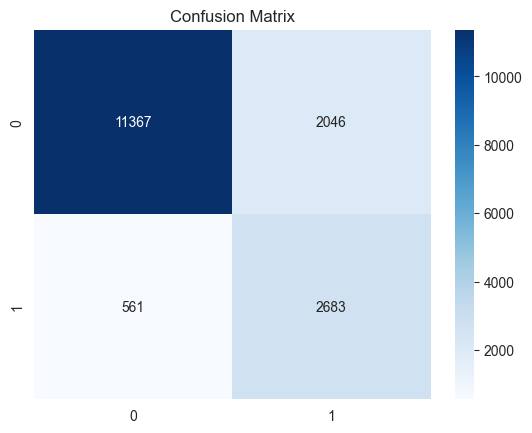


* CV (f1 score): XGBoost (500 estimators)
     * Mean : 0.6758662150237292
     * Std : 0.003472521869325704

### Upsampled Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.985209468525149,
 'gamma': 4.866388398218948e-05,
 'learning_rate': 0.0806777695575027,
 'max_depth': 22.0,
 'min_child_weight': 0.9682785419645363,
 'reg_alpha': 8.014544803174525,
 'reg_lambda': 1.040127534645051,
 'scale_pos_weight': 2.739947349919666,
 'subsample': 0.7884793754355912}

* Metrics : Metrics : 
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     13413
         1.0       0.53      0.87      0.66      3244

    accuracy                           0.83     16657

    macro avg       0.75      0.84      0.77     16657
   
    weighted avg       0.88      0.83      0.84     16657

* Confussion Matrix:

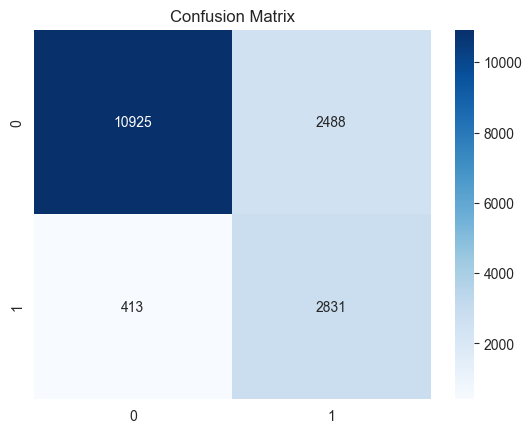

### Downsampling Data

* Model : XGBoost (100 estimators)
* Parameters : {'colsample_bytree': 0.8235873445603422,
 'gamma': 0.000128670224749042,
 'learning_rate': 0.17072875402514398,
 'max_depth': 14.0,
 'min_child_weight': 5.381336679960081,
 'reg_alpha': 9.187923998981237,
 'reg_lambda': 1.7522699976501133,
 'scale_pos_weight': 1.826877206585222,
 'subsample': 0.8790137193388823}

* Metrics : 
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83      3244
         1.0       0.79      0.95      0.86      3212

    accuracy                           0.84      6456
   macro avg       0.86      0.85      0.84      6456
weighted avg       0.86      0.84      0.84      6456

* Confussion Matrix:

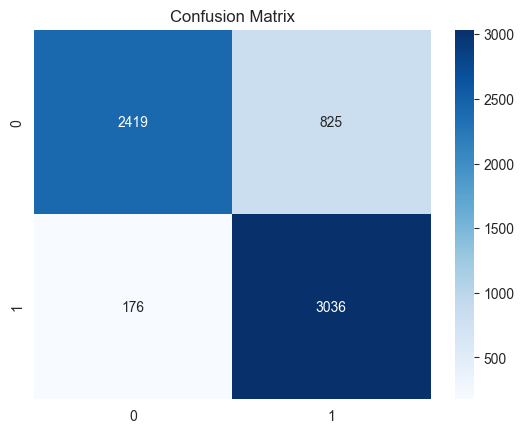

* Cross Validation : Mean F1 score :  0.8538944131112791, Std F1 :  0.004353035928353753